# 实验三 模式识别与机器学习实验——基于分类算法的机器人地点识别

## 一、实验目的

1. 掌握分类算法（KNN 算法、贝叶斯算法、决策树算法）的基本和原理应用。
   
2. 理解聚类算法（K-means 算法）的思想与实现。
   
3. 能够运用不同图像特征提取算法（直方图特征、SIFT 算法）结合分类器进行地点识别，比较不同方法的性能。
   
4. 培养学生对机器人工程领域中模式识别与机器学习问题的分析和解决能力。

## 二、实验数据

实验中采用室内场景数据集，包含 18 个不同场景的图片数据，数据集已分为训练集和测试集，以便进行模型训练和测试。数据集的目录结构如下：

```plaintext
dataset
├── train
dataset/
├── 类别1/
│   ├── 图片1.jpg
│   ├── 图片2.jpg
│   └── ...
├── 类别2/
│   ├── 图片1.jpg
│   ├── 图片2.jpg
│   └── ...
└── ...

每个场景类别对应一个独立的文件夹，文件夹内包含该场景下的图片样本。这样文件夹名称几位类别标签，每个类别文件夹下存在的图片样本支持格式为.jpg、.png、.jpeg等。

训练集和测试集的划分比例为 8:2，即训练集包含 2437 张图片样本，测试集包含 616 张图片样本。划分结果保存在两个文件中，分别为train.txt和test.txt。

通过以下代码导入训练数据集和测试数据集：

In [47]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns
from tqdm import tqdm

In [48]:
def load_dataset(file_path):
    """加载数据集文件，返回图像路径列表和对应的标签"""
    images = []
    labels = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            category, image_name = line.strip().split('/')
            image_path = os.path.join('dataset', category, image_name)
            images.append(image_path)
            labels.append(category)
    return images, labels

正在加载训练数据...

测试数据集信息:
图像数量: 1650
标签数量: 1650

前5个样本的信息:
样本 1:
  图像路径: dataset\gym\gimnasio_29_23_flickr.jpg
  类别标签: gym
样本 2:
  图像路径: dataset\gym\gym07.jpg
  类别标签: gym
样本 3:
  图像路径: dataset\gym\gym13.jpg
  类别标签: gym
样本 4:
  图像路径: dataset\gym\gimnasio_17_08_altavista.jpg
  类别标签: gym
样本 5:
  图像路径: dataset\gym\gym_21_01_altavista.jpg
  类别标签: gym


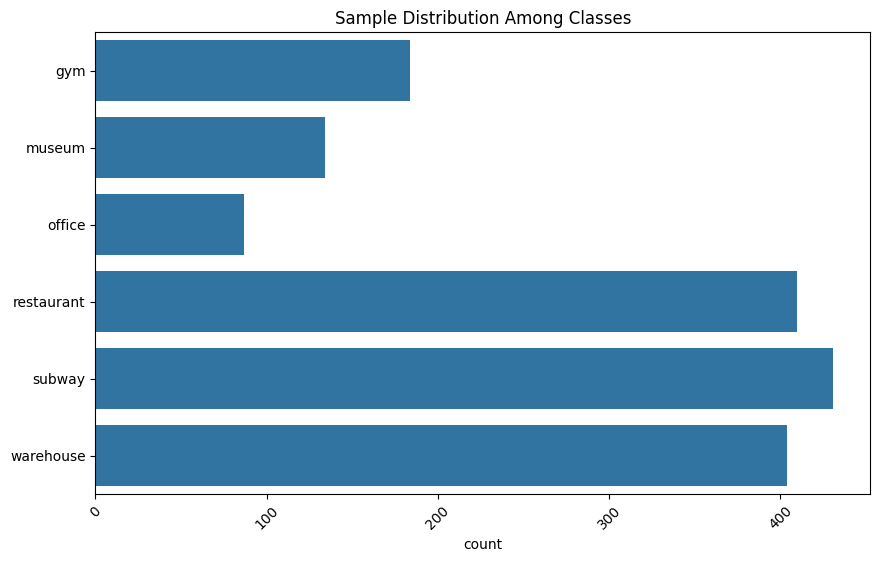

In [49]:
# 加载训练数据
print("正在加载训练数据...")
train_images, train_labels = load_dataset('train.txt')

# 展示测试数据的基本信息
print("\n测试数据集信息:")
print(f"图像数量: {len(train_images)}")
print(f"标签数量: {len(train_labels)}")
print("\n前5个样本的信息:")
for i in range(min(5, len(train_images))):
    print(f"样本 {i+1}:")
    print(f"  图像路径: {train_images[i]}")
    print(f"  类别标签: {train_labels[i]}")

# 显示每个类别的样本数量分布
plt.figure(figsize=(10, 6))
sns.countplot(train_labels)
plt.title('Sample Distribution Among Classes')
plt.xticks(rotation=45)
plt.show()

正在加载测试数据...

测试数据集信息:
图像数量: 416
标签数量: 416

前5个样本的信息:
样本 1:
  图像路径: dataset\gym\gimnasio_48_05_altavista.jpg
  类别标签: gym
样本 2:
  图像路径: dataset\gym\salle_9.jpg
  类别标签: gym
样本 3:
  图像路径: dataset\gym\Weight_Room.jpg
  类别标签: gym
样本 4:
  图像路径: dataset\gym\gimnasio_24_12_altavista.jpg
  类别标签: gym
样本 5:
  图像路径: dataset\gym\gimnasio_18_07_altavista.jpg
  类别标签: gym


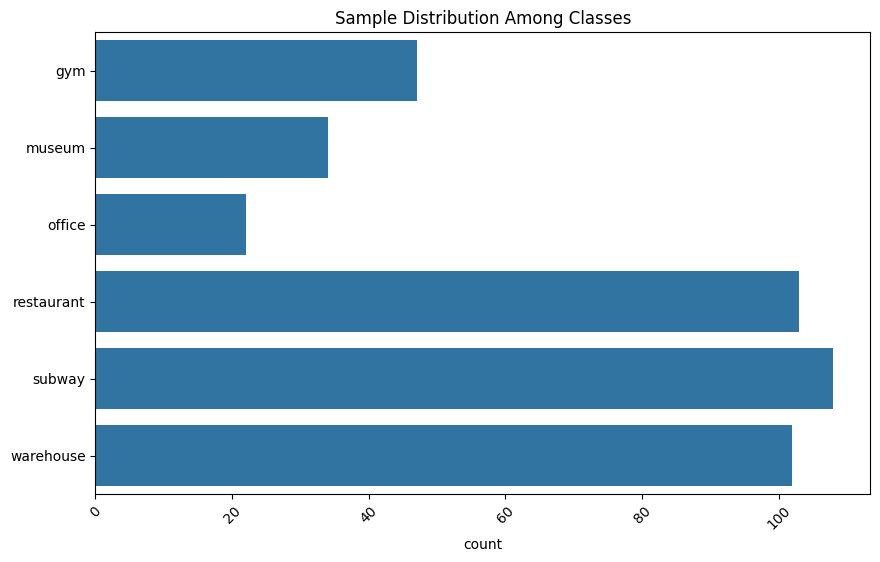

In [50]:
# 加载测试数据
print("正在加载测试数据...")
test_images, test_labels = load_dataset('test.txt')

# 展示训练数据的基本信息
print("\n测试数据集信息:")
print(f"图像数量: {len(test_images)}")
print(f"标签数量: {len(test_labels)}")
print("\n前5个样本的信息:")
for i in range(min(5, len(test_images))):
    print(f"样本 {i+1}:")
    print(f"  图像路径: {test_images[i]}")
    print(f"  类别标签: {test_labels[i]}")

# 统计各类别的样本数量
from collections import Counter
label_counts = Counter(test_labels)

# 显示每个类别的样本数量分布
plt.figure(figsize=(10, 6))
sns.countplot(test_labels)
plt.title('Sample Distribution Among Classes')
plt.xticks(rotation=45)
plt.show()

## 三、实验步骤

典型的机器学习算法的部署流程如下：

![机器学习模型部署流程](机器学习模型部署流程.png)

显然，在前面的实验数据介绍中，已经完成了数据集的获取，接下来应该进行数据的预处理工作。实验数据的预处理工作包括：实验数据的缺失值处理、异常值处理、数据标准化等。这里假定已经完成了数据的预处理工作。

对于图像识别任务来说，在进行数据预处理时，图像数据的的增强工作是必不可少的。图像数据的增强工作包括：图像的翻转、图像的旋转、图像的缩放、图像的平移等。图像增强的目的是为了增加数据集的多样性，从而提高模型的泛化能力。这里将图像数据的增强作为扩展实验的一部分，由大家自行撰写代码实现。



In [51]:
def data_enhancement(train_images, train_labels):
    # 数据增强
    # 旋转
    # 平移
    # 缩放
    # 镜像
    # 噪声
    # 裁剪
    # 颜色变换
    # 对比度变换
    # 亮度变换
    # 锐化
    # 模糊
    # 高斯噪声
    # 椒盐噪声
    # 泊松噪声
    # 高斯模糊
    # 中值模糊
    # 双边模糊
    # 拉普拉斯模糊
    # 高斯双边模糊
    pass
    return train_images, train_labels

### 特征提取——用像素形成特征


完成了数据集的获取，并跳过了数据预处理过程后，就来到了模型训练部分。分类器能够实现分类的前提是能够提取出特征。对于图像数据来说，最容易提取的特征就是直接利用图像中的像素。这时，我们将图像按照先行后列的方式展开为向量的形式，即得到了输入分类器的特征。当然考虑到数据集中图像的大小不一，因此在进行图像展开之前，通过图像缩放，得到统一的图像尺寸，然后再将图像展开为向量。

![将图像展开为向量](将图像展开为向量.png)


        

In [52]:
def extract_features(image_path):
    """提取图像特征
    将图像调整为64×64大小，然后按RGB通道展开为特征向量"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法读取图像: {image_path}")
    
    # 调整图像大小为128×128
    image = cv2.resize(image, (128, 128))
    
    # 将图像展平为一维向量，按RGB通道交错排列
    # reshape(-1, 3)将图像展平为N×3的矩阵，每行是一个像素的RGB值
    # reshape(1, -1)将N×3的矩阵展平为一维向量
    features = image.reshape(-1, 3).reshape(1, -1)[0]
    
    # 归一化特征向量，使值范围在[0,1]之间
    features = features.astype(float) / 255.0
    
    return features

对训练集和测试集中的图像数据分别进行图特征的提取，特征提取过程的代码如下：

In [53]:
# 提取训练集特征
print("正在提取训练集特征...")

X_train = []
# 使用tqdm包装train_images迭代器来显示进度条
for image_path in tqdm(train_images, desc="特征提取进度"):
    features = extract_features(image_path)
    X_train.append(features)
X_train = np.array(X_train)

# 展示特征矩阵的信息
print("\n特征矩阵信息:")
print(f"特征矩阵形状: {X_train.shape}")
print(f"特征矩阵类型: {X_train.dtype}")

# 展示前两个样本的特征向量
print("\n前两个样本的特征向量片段:")
for i in range(min(2, len(X_train))):
    print(f"\n样本 {i+1} 的前10个特征值:")
    print(X_train[i][:10])

# 计算并展示每个类别的平均特征值
class_features = {}
for label in np.unique(train_labels):
    mask = np.array(train_labels) == label
    class_features[label] = np.mean(X_train[mask], axis=0)

正在提取训练集特征...


特征提取进度: 100%|██████████| 1650/1650 [00:06<00:00, 259.03it/s]



特征矩阵信息:
特征矩阵形状: (1650, 49152)
特征矩阵类型: float64

前两个样本的特征向量片段:

样本 1 的前10个特征值:
[0.69411765 0.8627451  0.81960784 0.69019608 0.86666667 0.81568627
 0.69019608 0.87058824 0.82352941 0.69411765]

样本 2 的前10个特征值:
[0.72156863 0.74901961 0.78823529 0.82745098 0.85490196 0.88235294
 0.96862745 0.97647059 0.98431373 0.91372549]


In [54]:
# 提取测试集特征
print("正在提取测试集特征...")
X_test = []
for image_path in tqdm(test_images, desc="特征提取进度"):
    features = extract_features(image_path)
    X_test.append(features)
X_test = np.array(X_test)

正在提取测试集特征...


特征提取进度: 100%|██████████| 416/416 [00:01<00:00, 262.60it/s]


#### KNN分类器

通过特征提取，将二维图像转化为一维向量表示，就可以送入分类器模型，进行分类模型的训练了。这里先采用最简单的KNN分类算法，将模型训练和测试的过程进行展示。

In [55]:
# 训练KNN分类器
from sklearn.neighbors import KNeighborsClassifier
print("Training KNN classifier...")

# 创建并训练KNN分类器
classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform')  # 使用5个近邻，权重统一
classifier.fit(X_train, train_labels)

Training KNN classifier...


KNeighborsClassifier()



为了展示KNN分类算法的训练过程，实验定义了一个叫做plot_learning_curve的函数，该函数通过scikit-learn的learning_curve方法，计算并展示了模型在不同训练样本数量下的性能表现。函数首先创建一个10x6大小的图表窗口，并设置了相应的标题和坐标轴标签。在计算学习曲线时，函数使用交叉验证的方式，将数据集按照从10%到100%的比例划分为5个点，分别计算模型在这些不同规模训练集上的表现。对于每个训练集大小，函数计算了训练集和交叉验证集上的平均得分和标准差。在可视化展示中，使用红色曲线表示训练集得分，绿色曲线表示交叉验证集得分，同时用浅色区域展示了得分的标准差范围，这有助于我们观察模型性能的稳定性。通过这个学习曲线，我们可以直观地判断模型是否存在过拟合或欠拟合问题，评估训练样本数量对模型性能的影响，并决定是否需要增加训练数据来提升模型性能。

        

In [56]:
# 绘制学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                       n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation Score")
    plt.legend(loc="best")
    return plt

调用plot_learning_curve()函数，绘制学习曲线。注意调用过程中的输入数据是向量特征X_train和标签集合train_labels，而不是原始的图像数据集合train_images和标签集合train_labels。

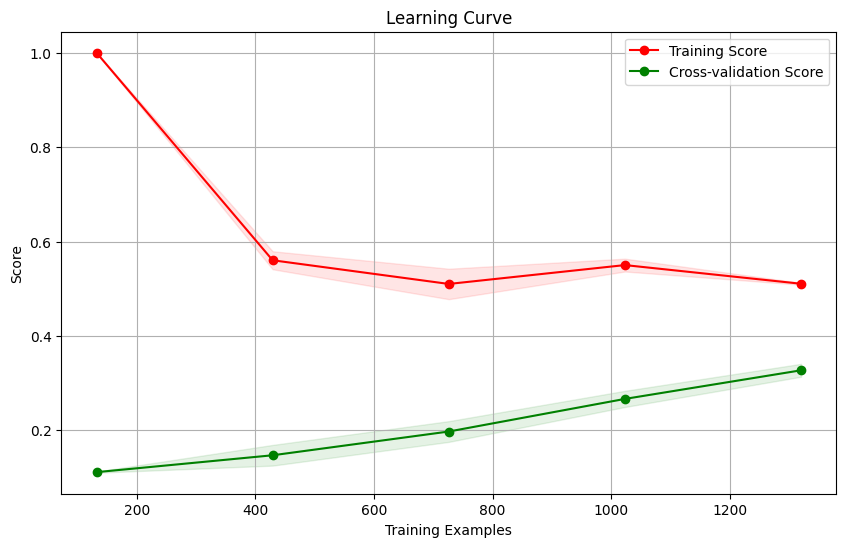

In [57]:
# 绘制学习曲线
plot_learning_curve(classifier, "Learning Curve", X_train, train_labels)
plt.show()

**实验思考**

在上图中，训练得分和交叉验证得分的变化趋势说明了什么？

(双击此处添加你得答案)

在训练集上完成了KNN分类器模型的训练以后，就可以在测试集上进行测试了。代码如下：

In [58]:
# 进行预测
print("正在进行预测...")
predictions = classifier.predict(X_test)

正在进行预测...




为了对测试结果进行评价，使用了多个评估指标来衡量分类模型的性能。

首先，使用准确率（Accuracy）作为基本指标，其计算公式为 

$$Accuracy = \frac{正确预测的样本数}{总样本数}$$

直观反映模型的整体预测准确性。

其次，展示了每个类别的精确率（Precision）、召回率（Recall）和F1分数。其中，精确率为

$$Precision = \frac{TP}{TP+FP}$$

反映了模型预测为正例中真实正例的比例，

召回率为 

$$Recall = \frac{TP}{TP+FN}$$ 

表示真实正例中被正确预测的比例，

F1分数则是精确率和召回率的调和平均 

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

通过混淆矩阵（Confusion Matrix）可视化了各类别之间的预测情况，其中每个单元格 $(i,j)$ 表示真实类别为 $i$ 但被预测为类别 $j$ 的样本数量。

最后，通过ROC曲线（Receiver Operating Characteristic）和AUC值（Area Under Curve）评估了模型的分类性能，ROC曲线横轴为假阳性率 $FPR = \frac{FP}{FP+TN}$，纵轴为真阳性率 $TPR = \frac{TP}{TP+FN}$，AUC值越接近1表示模型性能越好。这些指标的综合分析能够全面评估模型在不同方面的表现，帮助我们更好地理解和改进模型。

        

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from collections import Counter
def evaluate_and_visualize(classifier, test_labels, predictions, X_test):
    """
    评估模型性能并可视化结果
    
    参数:
    classifier: 训练好的分类器模型
    test_labels: 测试集的真实标签
    predictions: 模型预测结果
    X_test: 测试集特征矩阵
    """
    # 计算并显示基本评估指标
    accuracy = accuracy_score(test_labels, predictions)
    print(f"\nAccuracy: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))

    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 计算并绘制ROC曲线和AUC
    plt.figure(figsize=(10, 8))
    
    # 获取预测概率
    y_prob = classifier.predict_proba(X_test)
    
    # 为每个类别计算ROC曲线
    for i in range(len(classifier.classes_)):
        # 将当前类别的标签转换为二进制
        y_true_binary = (np.array(test_labels) == classifier.classes_[i]).astype(int)
        
        # 计算ROC曲线
        fpr, tpr, _ = roc_curve(y_true_binary, y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        
        # 绘制ROC曲线
        plt.plot(fpr, tpr, label=f'{classifier.classes_[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


Accuracy: 31.25%

Classification Report:
              precision    recall  f1-score   support

         gym       0.18      0.17      0.18        47
      museum       0.23      0.18      0.20        34
      office       0.20      0.09      0.13        22
  restaurant       0.41      0.12      0.18       103
      subway       0.36      0.19      0.25       108
   warehouse       0.33      0.80      0.46       102

    accuracy                           0.31       416
   macro avg       0.29      0.26      0.23       416
weighted avg       0.33      0.31      0.27       416



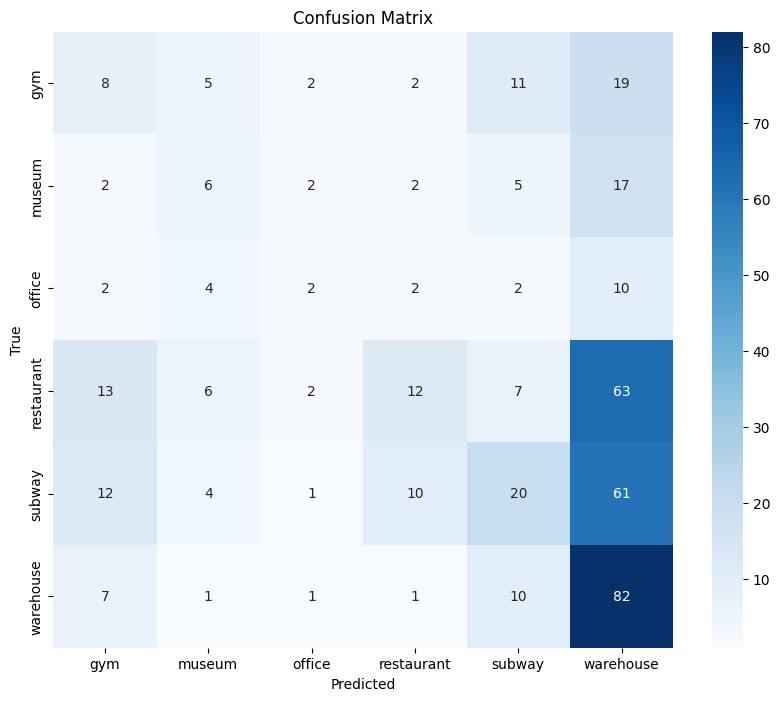

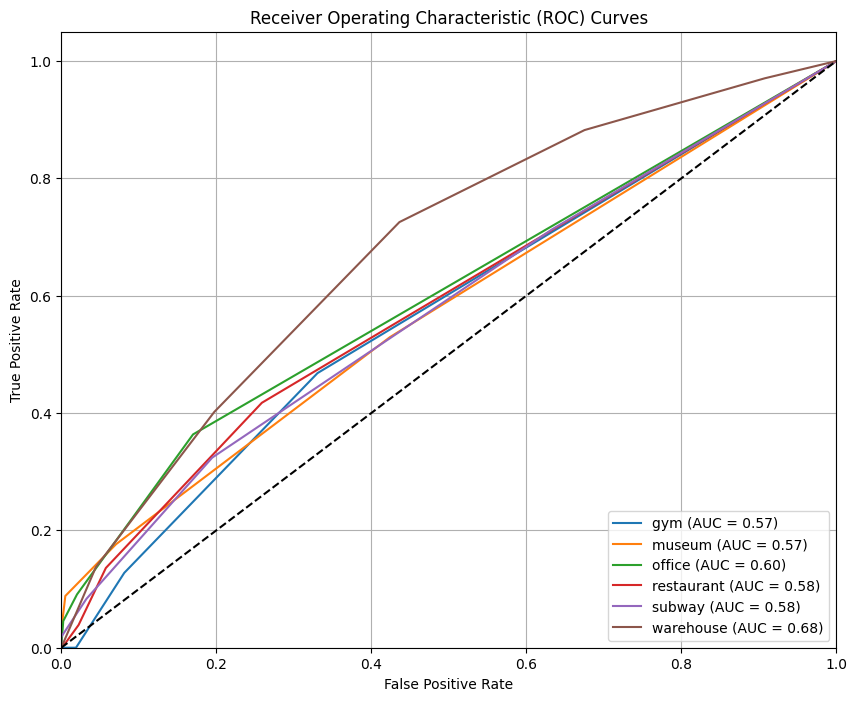

In [60]:
# 在得到预测结果后调用此函数
evaluate_and_visualize(classifier, test_labels, predictions, X_test)

**实验思考**

上面对于分类器的测试结果说明了什么？

(双击此处添加你的思考和分析)

#### 朴素贝叶斯分类器

在之前建立的图像特征的基础上，改用朴素贝叶斯分类器进行分类。假定特征之间相互独立，似然函数服从高斯分布，从而形成了高斯朴素贝叶斯分类器。


In [ ]:
from sklearn.naive_bayes import GaussianNB
# 训练贝叶斯分类器
print("Training classifier...")

# TODO：在此处添加你的代码
？？？？？？？？？？？？？？？？？？？？？

Training classifier...


GaussianNB()

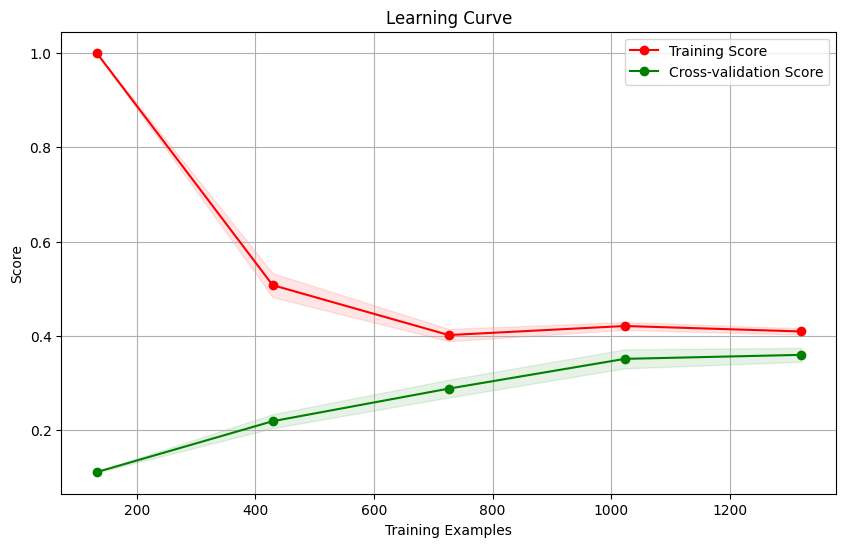

In [62]:
# 绘制学习曲线
plot_learning_curve(classifier, "Learning Curve", X_train, train_labels)
plt.show()

In [ ]:
# 进行预测
print("正在进行预测...")
# TODO：在此添加预测代码
？？？？？？？？？？？？？？？？？？？？？？？

正在进行预测...



Accuracy: 34.62%

Classification Report:
              precision    recall  f1-score   support

         gym       0.20      0.21      0.21        47
      museum       0.15      0.15      0.15        34
      office       0.13      0.45      0.21        22
  restaurant       0.54      0.15      0.23       103
      subway       0.44      0.56      0.49       108
   warehouse       0.47      0.43      0.45       102

    accuracy                           0.35       416
   macro avg       0.32      0.32      0.29       416
weighted avg       0.40      0.35      0.34       416



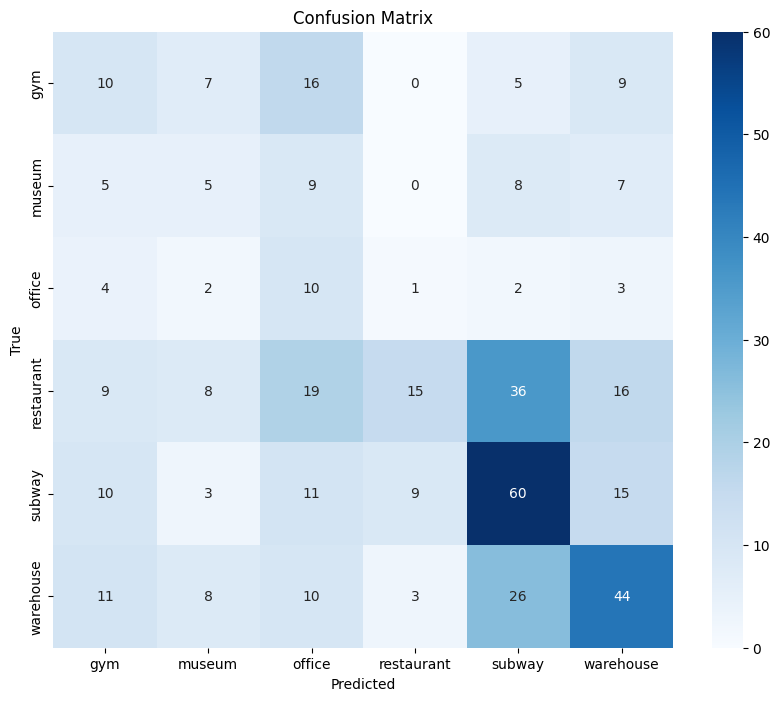

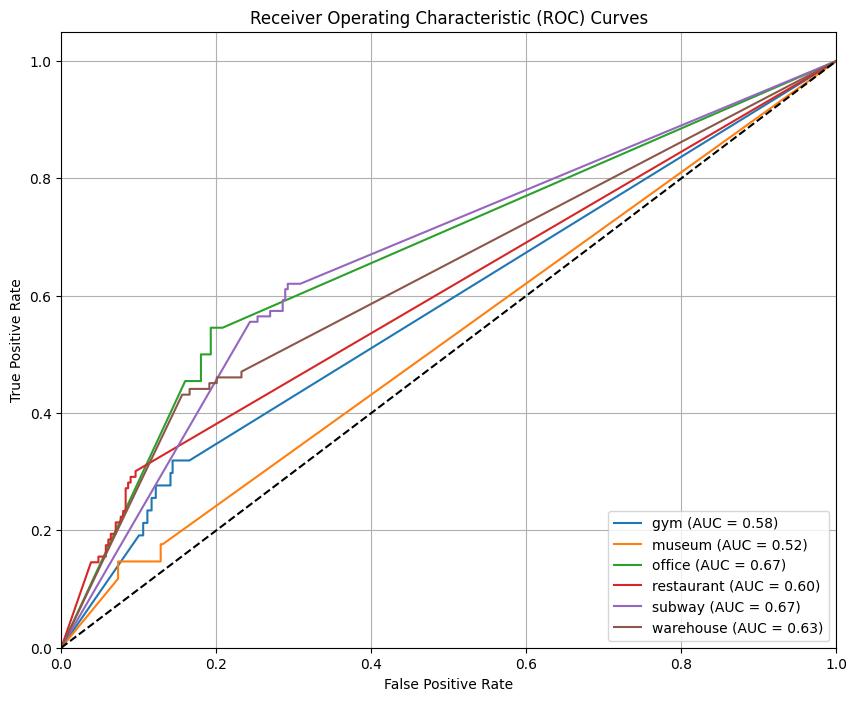

In [64]:
# 在得到预测结果后调用此函数
evaluate_and_visualize(classifier, test_labels, predictions, X_test)

**实验思考**

上面的实验结果说明了什么？

(双击此处添加你的思考)

#### 决策树分类器

采用决策树分类器进行分类。请撰写模型训练、预测、评价的代码。

In [ ]:
# TODO：撰写决策树分类器的模型训练、预测、评价的代码
？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

### 特征提取——SIFT特征

 前面的实验中，直接将图像的像素作为特征，送入分类器中进行分类。实际在深度学习兴起之前，已经产生了一些非常著名的图像特征提取方法，如SIFT、HOG、LBP等。这里我们就是用SIFT特征进行图像的特征提取，然后再送入分类其中进行分类，查看是否能够提高分类的性能。

 SIFT算法会利用高斯金字塔在图像中确定关键点，然后再用DOG算子确定关键点的方向，最后利用高斯函数对关键点周围的像素加权，最后得到关键点的描述子。每个描述子可以看作是长度为128维的向量。

随机选择的图像类别: restaurant
图像路径: dataset\restaurant\restaurant_25_12_altavista.jpg


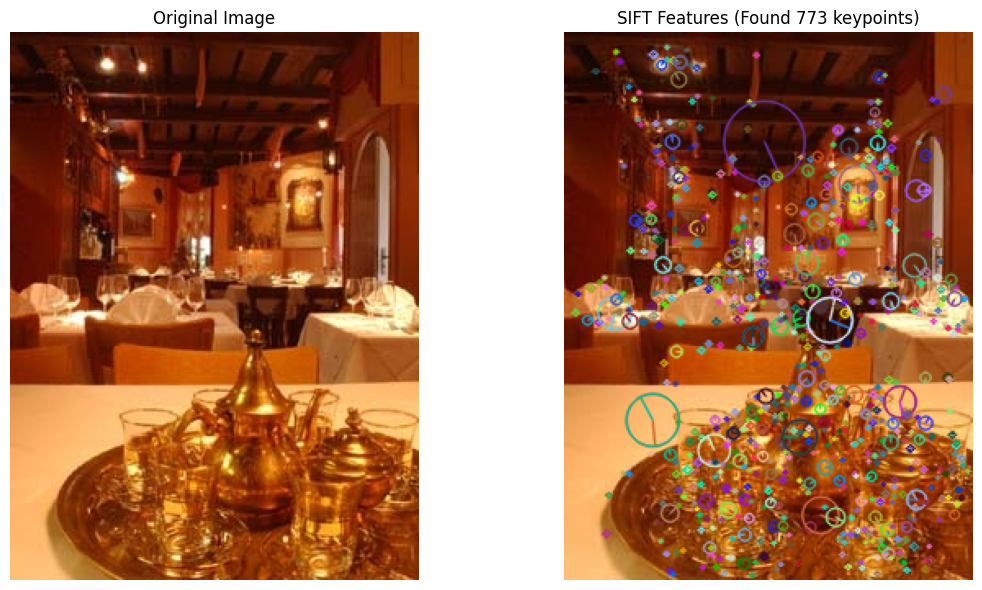

检测到的特征点数量: 773
特征描述符维度: (773, 128)


In [66]:
import cv2
import numpy as np
import random
import os

# 随机选择一张图像
def get_random_image(dataset_path):
    """从数据集中随机选择一张图像"""
    # 获取所有类别文件夹
    categories = os.listdir(dataset_path)
    # 随机选择一个类别
    category = random.choice(categories)
    category_path = os.path.join(dataset_path, category)
    
    # 获取该类别下的所有图像
    images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    # 随机选择一张图像
    image_name = random.choice(images)
    image_path = os.path.join(category_path, image_name)
    
    return image_path, category

# 提取并显示SIFT特征
def show_sift_features(image_path):
    """提取并显示图像的SIFT特征点"""
    # 读取图像
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法读取图像: {image_path}")
    
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 创建SIFT特征提取器
    sift = cv2.SIFT_create()
    
    # 检测关键点和描述符
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    # 绘制特征点
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # 显示结果
    plt.figure(figsize=(12, 6))
    
    # 显示原图
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # 显示特征点
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Features (Found {len(keypoints)} keypoints)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return keypoints, descriptors

# 使用示例
dataset_path = "dataset"  # 替换为你的数据集路径
image_path, category = get_random_image(dataset_path)
print(f"随机选择的图像类别: {category}")
print(f"图像路径: {image_path}")

# 显示SIFT特征
keypoints, descriptors = show_sift_features(image_path)
print(f"检测到的特征点数量: {len(keypoints)}")
print(f"特征描述符维度: {descriptors.shape if descriptors is not None else 'None'}")

由上图中不难发现，对于一幅给定的图像，SIFT算法会找出很多关键点，所以会得到很多描述子。因此下面的代码先对一幅图像中的描述子进行了聚类分析，再根据聚类的大小将聚类中心进行拼接形成输入分类器的特征向量。

In [67]:
def extract_features(image_path):
    """使用SIFT提取图像特征，对描述子进行聚类，并按聚类大小排序拼接聚类中心"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法读取图像: {image_path}")
    
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 创建SIFT特征提取器
    sift = cv2.SIFT_create()
    
    # 检测关键点和描述符
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    # 如果没有检测到特征点，返回零向量
    if descriptors is None or len(descriptors) < 10:
        return np.zeros(128 * 10)
    
    # 使用K-means对描述子进行聚类
    from sklearn.cluster import KMeans
    n_clusters = min(10, len(descriptors))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(descriptors)
    
    # 获取每个聚类的大小
    cluster_sizes = np.bincount(kmeans.labels_)
    
    # 获取聚类中心并按照聚类大小排序
    centers = kmeans.cluster_centers_
    sorted_indices = np.argsort(-cluster_sizes)  # 降序排序
    sorted_centers = centers[sorted_indices]
    
    # 如果聚类数量不足10个，用零向量补足
    if n_clusters < 10:
        padding = np.zeros((10 - n_clusters, 128))
        sorted_centers = np.vstack([sorted_centers, padding])
    
    # 归一化特征向量
    normalized_centers = cv2.normalize(sorted_centers, None)
    
    # 将所有聚类中心拼接成一个向量
    feature_vector = normalized_centers.flatten()
    
    return feature_vector

对于训练集中的图像进行SIFT特征的提取。

In [68]:
# 提取训练集特征
print("正在提取训练集特征...")

X_train = []
# 使用tqdm包装train_images迭代器来显示进度条
for image_path in tqdm(train_images, desc="特征提取进度"):
    features = extract_features(image_path)
    X_train.append(features)
X_train = np.array(X_train)

# 展示特征矩阵的信息
print("\n特征矩阵信息:")
print(f"特征矩阵形状: {X_train.shape}")
print(f"特征矩阵类型: {X_train.dtype}")

# 展示前两个样本的特征向量
print("\n前两个样本的特征向量片段:")
for i in range(min(2, len(X_train))):
    print(f"\n样本 {i+1} 的前10个特征值:")
    print(X_train[i][:10])

# 计算并展示每个类别的平均特征值
class_features = {}
for label in np.unique(train_labels):
    mask = np.array(train_labels) == label
    class_features[label] = np.mean(X_train[mask], axis=0)



正在提取训练集特征...


特征提取进度: 100%|██████████| 1650/1650 [01:39<00:00, 16.56it/s]


特征矩阵信息:
特征矩阵形状: (1650, 1280)
特征矩阵类型: float32

前两个样本的特征向量片段:

样本 1 的前10个特征值:
[0.01070462 0.00701863 0.01168848 0.01692647 0.02608602 0.02299589
 0.0142174  0.01019191 0.0409755  0.01836069]

样本 2 的前10个特征值:
[0.01561275 0.02844312 0.03050449 0.01717495 0.01094464 0.00993707
 0.01406904 0.01026984 0.01295979 0.02909943]


对于测试集同样采用前面的方法提取特征向量。

In [69]:
# 提取测试集特征
print("正在提取测试集特征...")
X_test = []
for image_path in tqdm(test_images, desc="特征提取进度"):
    features = extract_features(image_path)
    X_test.append(features)
X_test = np.array(X_test)

正在提取测试集特征...


特征提取进度: 100%|██████████| 416/416 [00:24<00:00, 16.90it/s]


#### KNN分类器

还是先从最简单的KNN分类器开始进行实验。

In [ ]:
# 训练KNN分类器
print("Training KNN classifier...")

# TODO: 创建并训练KNN分类器
？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

Training KNN classifier...


KNeighborsClassifier()

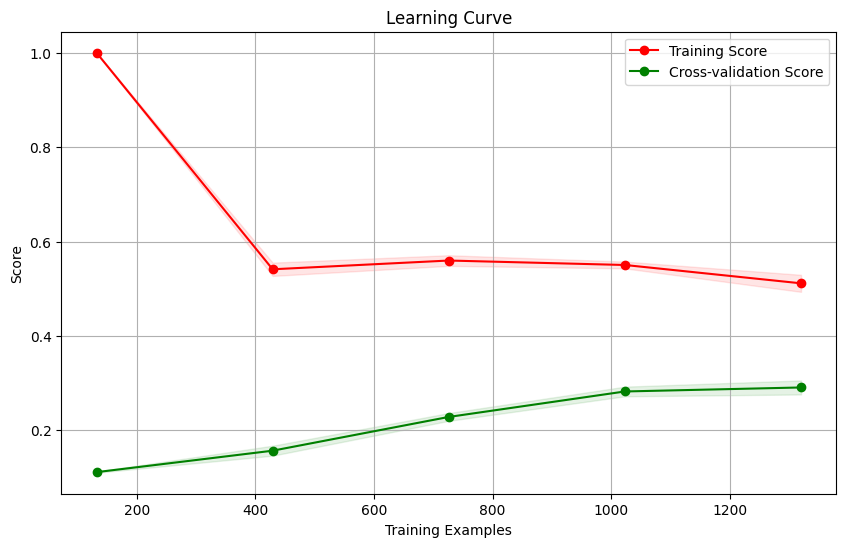

In [71]:
# 绘制学习曲线
plot_learning_curve(classifier, "Learning Curve", X_train, train_labels)
plt.show()

In [ ]:
# 进行预测
print("正在进行预测...")
# TODO: 请在此处编写代码
？？？？？？？？？？？？？？？？？？？？？？

正在进行预测...



Accuracy: 32.21%

Classification Report:
              precision    recall  f1-score   support

         gym       0.16      0.11      0.13        47
      museum       0.13      0.06      0.08        34
      office       0.00      0.00      0.00        22
  restaurant       0.32      0.49      0.38       103
      subway       0.48      0.24      0.32       108
   warehouse       0.33      0.50      0.40       102

    accuracy                           0.32       416
   macro avg       0.24      0.23      0.22       416
weighted avg       0.31      0.32      0.30       416



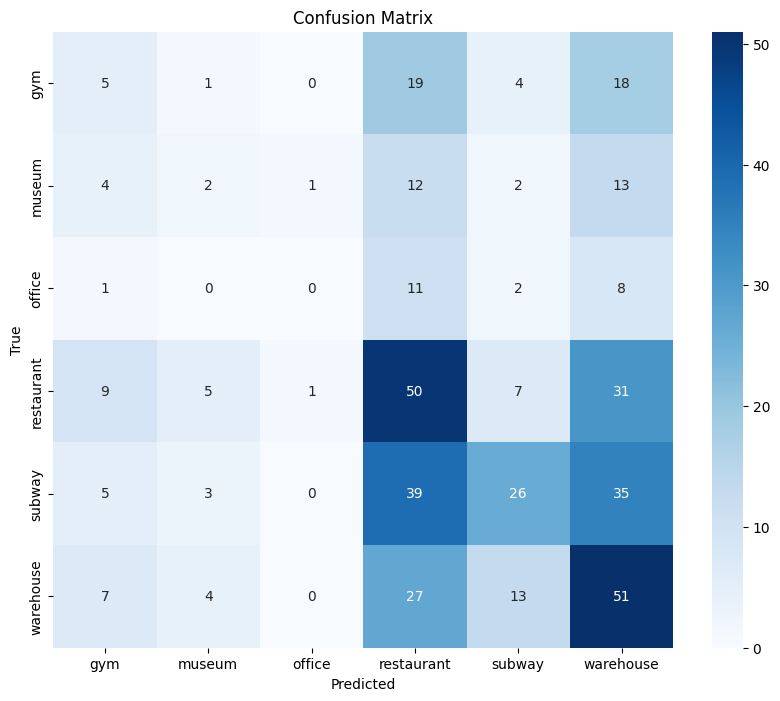

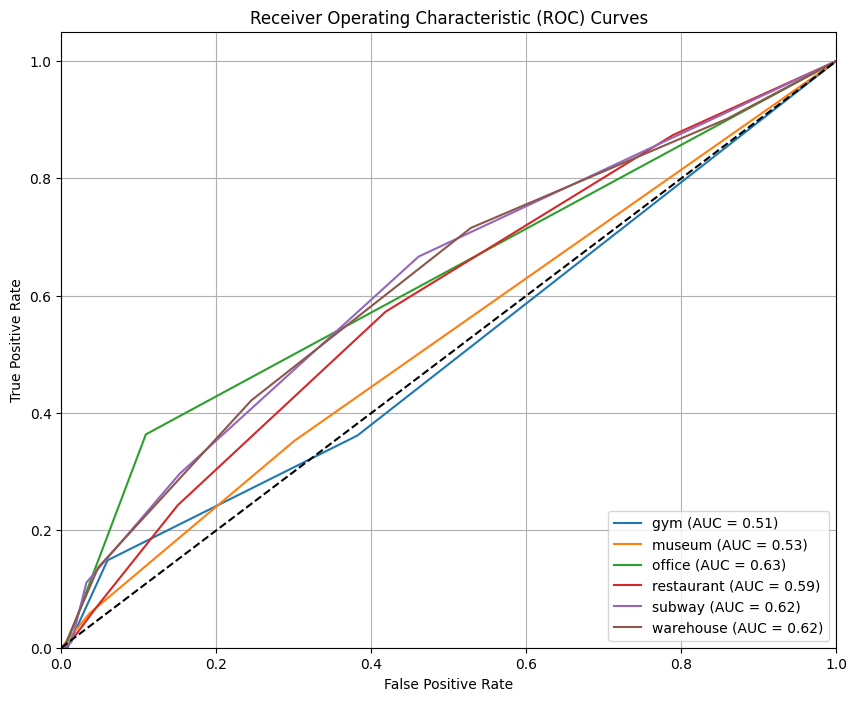

In [73]:
# 在得到预测结果后调用此函数
evaluate_and_visualize(classifier, test_labels, predictions, X_test)

**实验思考**

对比之前的实验结果，能够得出什么结论？

(双击此处添加你的思考)

#### 朴素贝叶斯分类器

利用朴素贝叶斯分类器对图像进行分类。

In [ ]:
# 训练贝叶斯分类器
print("Training classifier...")

# TODO：在此处添加训练分类器的代码
？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

Training classifier...


GaussianNB()

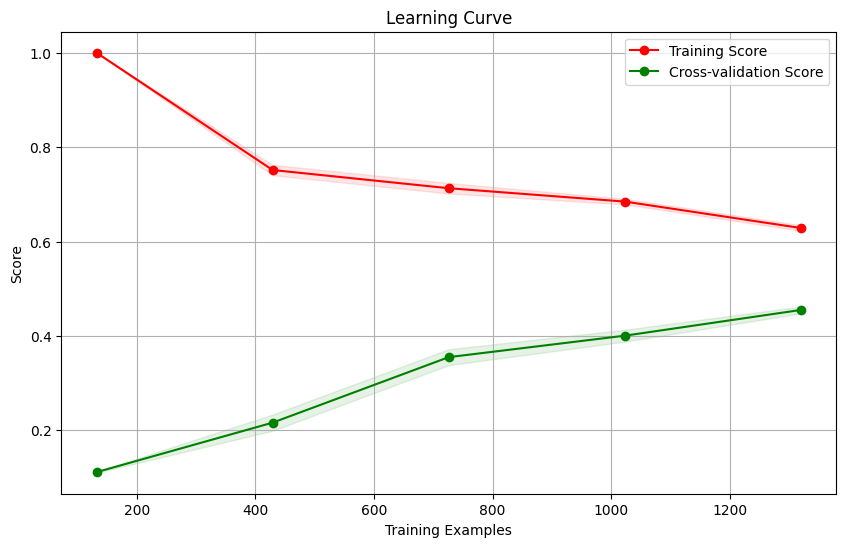

In [75]:
# 绘制学习曲线
plot_learning_curve(classifier, "Learning Curve", X_train, train_labels)
plt.show()

In [ ]:
# 进行预测
print("正在进行预测...")
# TODO：使用训练好的分类器对测试集进行预测
？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

正在进行预测...



Accuracy: 42.31%

Classification Report:
              precision    recall  f1-score   support

         gym       0.24      0.21      0.23        47
      museum       0.13      0.15      0.14        34
      office       0.18      0.23      0.20        22
  restaurant       0.48      0.49      0.48       103
      subway       0.59      0.56      0.57       108
   warehouse       0.45      0.45      0.45       102

    accuracy                           0.42       416
   macro avg       0.35      0.35      0.35       416
weighted avg       0.43      0.42      0.43       416



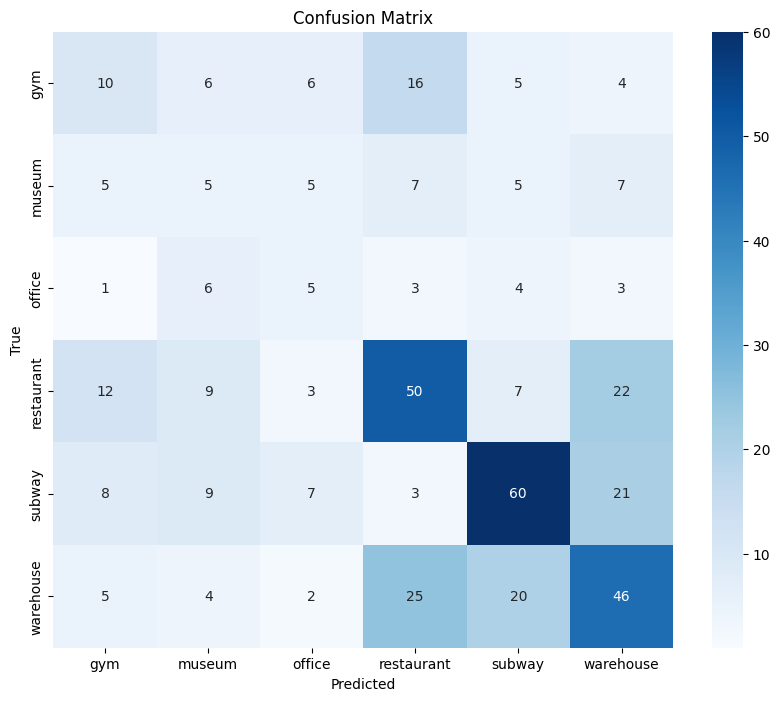

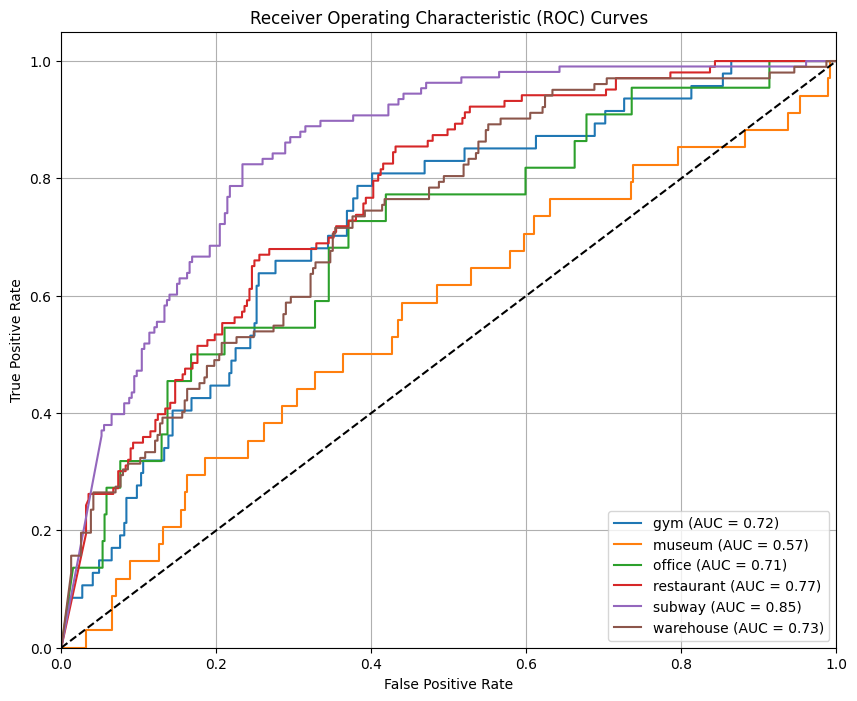

In [77]:
# 在得到预测结果后调用此函数
evaluate_and_visualize(classifier, test_labels, predictions, X_test)

**实验思考**

这次实验结果如何，该怎么评价呢？

(双击此处添加你的思考)

#### 决策树分类器

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 创建并训练决策树分类器
print("正在训练决策树分类器...")

# TODO：此处添加你的代码
？？？？？？？？？？？？？？？？？？？？？？？？？？

正在训练决策树分类器...


DecisionTreeClassifier(random_state=42)

In [ ]:
# 在测试集上进行预测
print("正在进行预测...")

# TODO: 对测试集进行预测
？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

正在进行预测...



Accuracy: 29.57%

Classification Report:
              precision    recall  f1-score   support

         gym       0.13      0.11      0.12        47
      museum       0.07      0.06      0.06        34
      office       0.08      0.09      0.09        22
  restaurant       0.34      0.37      0.36       103
      subway       0.41      0.30      0.34       108
   warehouse       0.33      0.43      0.37       102

    accuracy                           0.30       416
   macro avg       0.23      0.23      0.22       416
weighted avg       0.29      0.30      0.29       416



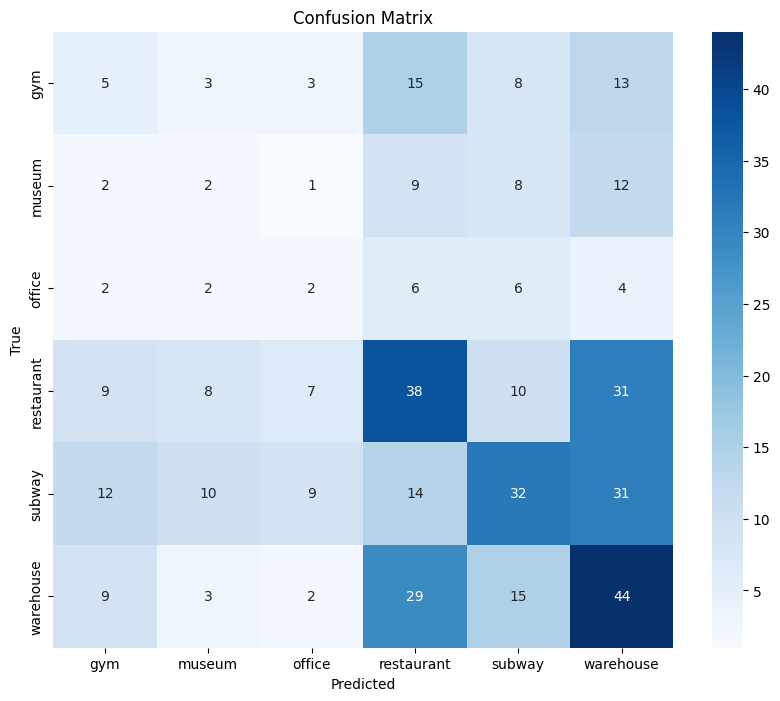

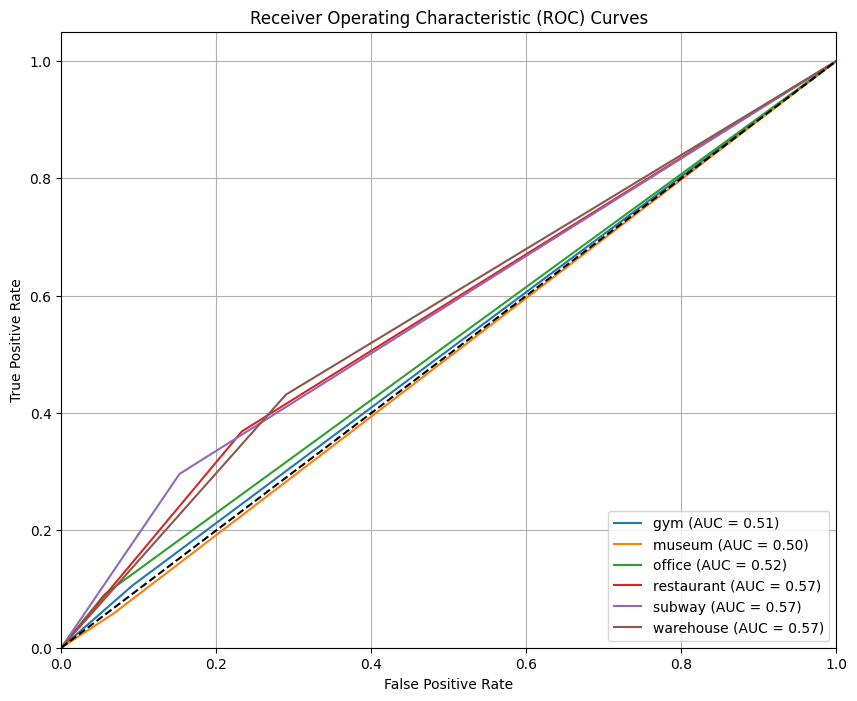

In [80]:
# 在得到预测结果后调用此函数
evaluate_and_visualize(classifier, test_labels, predictions, X_test)


**实验思考**

把三种分类器在不同特征提取测量略下的性能进行比较，分析其性能差异。

(双击此处添加你得思考)

### 扩展实验

如果你觉得特征提取的不够充分，或者你对这些分类器的性能都不满意，那么就去尝试一些更与众不同的方法吧！

In [81]:
#TODO：请在此处写入你自己的代码
def try_something_different():
    # 函数名称任意修改
    # 函数代码随便改
    # 能让我看到更优的实验效果就给你加分
    pass

### 聚类算法

实验的最后，体验一下K-means算法的使用。在之前SIFT特征提取的基础上，为了能够直观展示聚类算法，使用PCA降维到二维平面，然后使用K-means算法进行聚类。

In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# 使用最优聚类数训练模型
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X_train)

KMeans(n_clusters=6, n_init='auto', random_state=42)


各聚类的样本分布:
聚类 0: 265 个样本
聚类 1: 355 个样本
聚类 2: 183 个样本
聚类 3: 304 个样本
聚类 4: 226 个样本
聚类 5: 317 个样本


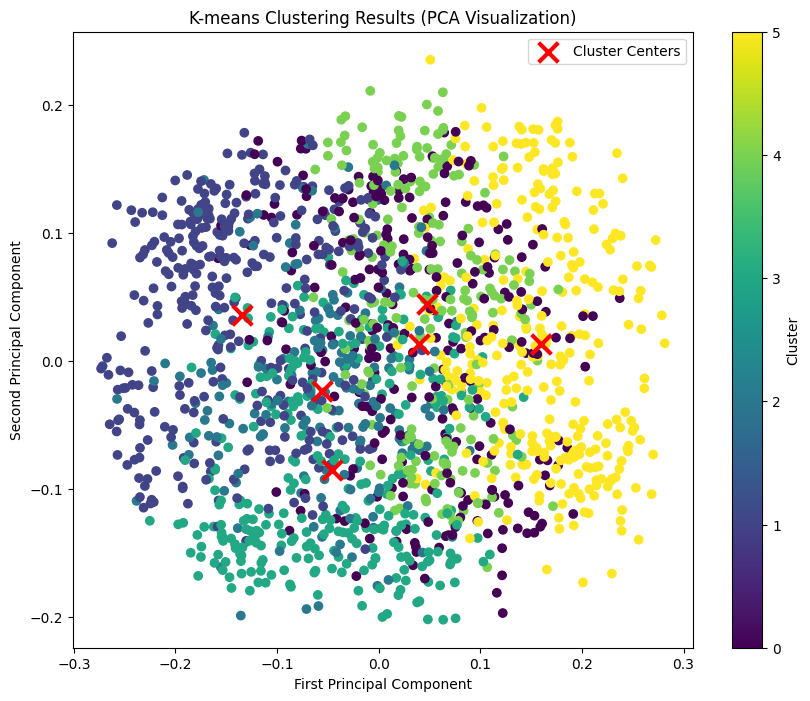

In [83]:
# 可视化聚类结果（使用PCA降维到2维）
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
centers_2d = pca.transform(kmeans.cluster_centers_)

# 输出每个聚类的样本数量
print("\n各聚类的样本分布:")
for i in range(n_clusters):
    print(f"聚类 {i}: {np.sum(kmeans.labels_ == i)} 个样本")
    
# Plot clustering results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
                     c=kmeans.labels_, cmap='viridis')
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('K-means Clustering Results (PCA Visualization)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

从这张图中也能够看出来，我们的数据集还是挺难划分的，不同的类别基本混淆在了一起，所以我们需要更强大的特征提取方法和分类器。